This Notebook comprises of the code for the time series forcarsting of Smart meter reading and then detecting the anomalies in it using **Seasonal Autoregressive Integrated Moving Average model**

In [1]:
# Importing the packages 
import pandas as pd
import numpy as np
# Using statsmodels package for ARIMA models
import statsmodels.api as sm
from statsmodels.tsa import arima_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams.update({'font.size': 10, 'axes.facecolor':[0.95, 0.95, 0.95]})

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


The test data is available at the [link text](https://www.cs.ucr.edu/~eamonn/time_series_data_2018/). The data is collected from smart meter of the hosuehold in UK.

In [2]:
#uploading the dataset
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving Smart_meter_Electrical_devices.csv to Smart_meter_Electrical_devices.csv
User uploaded file "Smart_meter_Electrical_devices.csv" with length 2228100 bytes


In [3]:
# Reading the dataset from the file
data = pd.read_csv('Smart_meter_Electrical_devices.csv', header=None, index_col=False)
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
0,1,1.06340,1.06340,1.06340,1.06340,1.06340,-0.630320,-0.86128,-0.86128,-0.86128,...,1.06340,1.06340,1.06340,1.06340,0.75542,-0.78429,-0.93826,-0.86128,-0.86128,-0.93826
1,1,-0.95341,-0.87025,0.62656,2.20650,1.87390,1.541300,1.54130,1.54130,1.20870,...,-0.87025,-0.87025,-0.95341,-0.87025,-0.87025,-0.87025,-0.95341,-0.87025,-0.87025,1.20870
2,1,1.09040,0.77728,1.09040,1.09040,1.09040,0.777280,0.30759,-0.86665,-0.94494,...,-0.94494,-0.86665,0.30759,1.09040,1.09040,1.09040,1.09040,1.09040,1.09040,0.77728
3,1,-0.84982,-0.84982,-0.92679,-0.84982,-0.84982,0.073874,1.07450,1.07450,1.07450,...,-0.92679,-0.84982,-0.84982,-0.92679,-0.84982,-0.84982,-0.92679,-0.77284,1.07450,1.07450
4,1,-0.90531,-0.43298,1.14150,1.14150,1.14150,1.141500,0.82659,1.14150,1.14150,...,-0.82659,-0.90531,-0.82659,-0.82659,-0.90531,-0.82659,-0.90531,-0.82659,-0.82659,-0.90531


In [4]:
# print the last values 

data.tail(5)

,0,1,2,3,4,5,6,7,8,9,...,711,712,713,714,715,716,717,718,719,720
370,3,-0.36130,-0.36130,0.066555,-0.36130,-0.36130,0.066555,-0.36130,0.066555,-0.36130,...,0.066555,-0.36130,0.066555,0.066555,-0.36130,0.066555,-0.36130,0.066555,0.066555,-0.36130
371,3,0.26593,-0.32441,0.265930,-0.32441,0.26593,-0.324410,0.26593,-0.324410,0.26593,...,-0.324410,0.26593,-0.324410,-0.324410,0.26593,-0.324410,-0.32441,0.265930,-0.324410,0.26593
372,3,-0.30926,-0.30926,0.270600,-0.30926,-0.30926,0.270600,-0.30926,-0.309260,0.27060,...,-0.309260,-0.30926,0.270600,-0.309260,-0.30926,0.270600,-0.30926,-0.309260,0.270600,-0.30926
373,3,-0.36006,-0.36006,0.240040,-0.36006,-0.36006,0.240040,-0.36006,0.240040,-0.36006,...,0.240040,-0.36006,-0.360060,0.240040,-0.36006,0.240040,-0.36006,0.240040,-0.360060,0.24004
374,3,-0.31519,0.27836,-0.315190,-0.31519,0.27836,-0.315190,-0.31519,0.278360,-0.31519,...,0.278360,-0.31519,-0.315190,0.278360,-0.31519,0.278360,-0.31519,-0.315190,0.278360,-0.31519


The first column indicates the three classes of electrical deivice present in the household (**Fridge/freezer, refrigerator, upright freezer**) and the indivdual column represents the time series data.

In [5]:
# For better visualization of TS data , Tranpose operation is performed
data = data.transpose()
print(data.ix[:5,:7])

        0        1        2        3        4        5        6        7
0  1.0000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000
1  1.0634 -0.95341  1.09040 -0.84982 -0.90531 -1.34960 -1.07870  1.06240
2  1.0634 -0.87025  0.77728 -0.84982 -0.43298  0.72227  0.85813 -0.93999
3  1.0634  0.62656  1.09040 -0.92679  1.14150  0.72227  0.85813  1.06240
4  1.0634  2.20650  1.09040 -0.84982  1.14150 -1.34960 -1.07870 -0.93999
5  1.0634  1.87390  1.09040 -0.84982  1.14150  0.72227  0.85813  1.06240


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [6]:
class1 = data.ix[:,data.ix[0] == 1]
print(class1.ix[:5,:7])

        0        1        2        3        4        5        6        7
0  1.0000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000
1  1.0634 -0.95341  1.09040 -0.84982 -0.90531 -1.34960 -1.07870  1.06240
2  1.0634 -0.87025  0.77728 -0.84982 -0.43298  0.72227  0.85813 -0.93999
3  1.0634  0.62656  1.09040 -0.92679  1.14150  0.72227  0.85813  1.06240
4  1.0634  2.20650  1.09040 -0.84982  1.14150 -1.34960 -1.07870 -0.93999
5  1.0634  1.87390  1.09040 -0.84982  1.14150  0.72227  0.85813  1.06240


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


**Analyzing the Time series data **

In [0]:
# Define function to plot the graph of TS 
def plot_ts(ts1, ts2, range1, range2):
    # Plot full length of ts
    plt.figure(figsize=(15,6))
    ax1 = plt.subplot(211)
    plt.plot(ts1[0], label=ts1[1])
    # If a second ts is passed, plot it
    if ts2:
        plt.plot(ts2[0], label=ts2[1])

    # Add a subplot for the first range passed
    if range1:
        ax3 = plt.subplot(223)
        plt.plot(ts1[0].iloc[range1[0]:range1[1]], label=ts1[1])
        if ts2:
            plt.plot(ts2[0].iloc[range1[0]:range1[1]], label=ts2[1])

    # Add a subplot for the second range passed
    if range2:
        ax4 = plt.subplot(224)
        plt.plot(ts1[0].iloc[range2[0]:range2[1]], label=ts1[1])
        if ts2:
            plt.plot(ts2[0].iloc[range2[0]:range2[1]], label=ts2[1])
    
    ax1.legend(loc='upper left');
    plt.show()

In [0]:
# Using the column number of TS analysis 
# The ts will hold the data of column 3 
ts = class1.ix[1:,3]

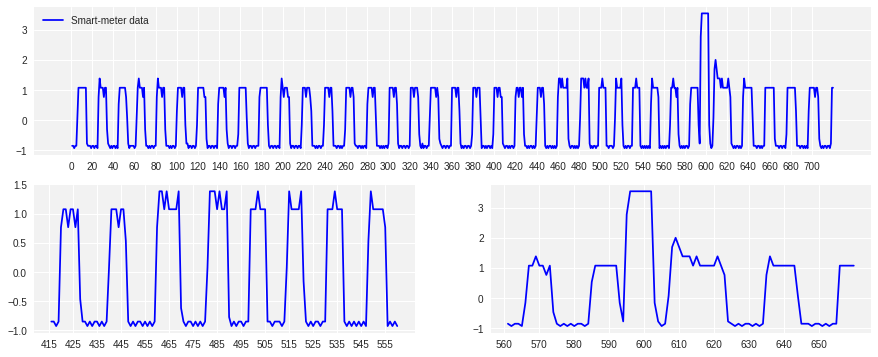

In [9]:
# Examine the time series visually

# Plot the whole series in upper plot and smaller portions in lower plots.
plot_ind1 = [415,560]
plot_ind2 = [560,660]

plt.figure(figsize=(15,6))
ax1 = plt.subplot(211)
plt.plot(ts, label='Smart-meter data', color='b')
ax1.legend(loc='upper left');
ax1.xaxis.set_ticks(np.arange(0, len(ts), 20));

ax3 = plt.subplot(223)
plt.plot(ts[plot_ind1[0]:plot_ind1[1]], label='Smart-meter data', color='b')
ax3.xaxis.set_ticks(np.arange(plot_ind1[0], plot_ind1[1], 10));

ax4 = plt.subplot(224)
plt.plot(ts[plot_ind2[0]:plot_ind2[1]], label='Smart-meter data', color='b')
ax4.xaxis.set_ticks(np.arange(plot_ind2[0], plot_ind2[1], 10));

plt.show()

From the graphical representation , it is clear that there are major anomaly at 600 -610 index and few in the range of [ 460,580].
The test data exhibits seasonality also as it shows the periodic behavior at an interval of 20 lags.

In [10]:
# Providing a sampling rate of 1/sec as the time index
dates = pd.date_range(start=pd.to_datetime('2018-01-01 00:00:01'), freq='1s', periods=len(ts))
ts_sec = pd.Series(data=ts.values, index=dates)
ts_sec.head()

2018-01-01 00:00:01   -0.84982
2018-01-01 00:00:02   -0.84982
2018-01-01 00:00:03   -0.92679
2018-01-01 00:00:04   -0.84982
2018-01-01 00:00:05   -0.84982
Freq: S, dtype: float64

In [0]:
# checking the stationarity of the series using ADF test 
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=20)
    rolstd = pd.rolling_std(timeseries, window=20)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).std()
  


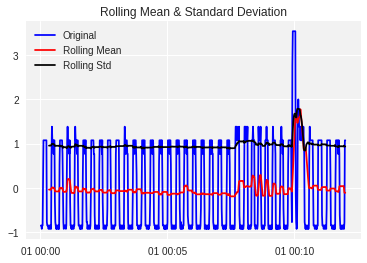

Results of Dickey-Fuller Test:
Test Statistic                  -3.612839
p-value                          0.005520
#Lags Used                      20.000000
Number of Observations Used    699.000000
Critical Value (1%)             -3.439740
Critical Value (5%)             -2.865684
Critical Value (10%)            -2.568977
dtype: float64


In [12]:
test_stationarity(ts_sec)

As the p-value <=0.05 , hence 95 % of the Null hypothesis is rejected and the TS is stationary but has a seasonality factor.

In [13]:
# Establish a training dataset
ts_train = pd.Series(ts_sec.ix[0:580])
ts_train.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


2018-01-01 00:09:36   -0.92679
2018-01-01 00:09:37   -0.84982
2018-01-01 00:09:38   -0.92679
2018-01-01 00:09:39   -0.84982
2018-01-01 00:09:40   -0.92679
Freq: S, dtype: float64

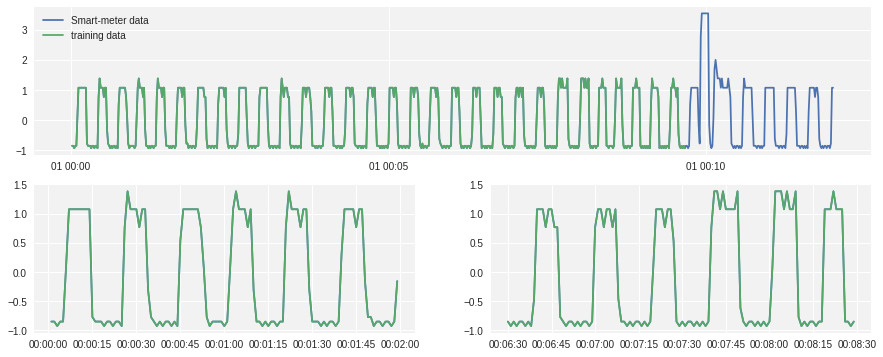

In [14]:
# Plotting the training data with actual data 


# Plot the whole series in upper plot and smaller portions in lower plots.
start_time_ord1 = ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:00:01'))
end_time_ord1 = ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:02:00'))

start_time_ord2 = ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:06:30'))
end_time_ord2 = ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:08:30'))

plot_range1 = [start_time_ord1,end_time_ord1]
plot_range2 = [start_time_ord2,end_time_ord2]

plot_ts([ts_sec, 'Smart-meter data'], [ts_train, 'training data'], plot_range1, plot_range2)

In [0]:
# Before using the Model , parameters need to be defined using Box-Jenkins Methodology 
# Define the function for plotting ACF and PACF graphs 
def plot_acfs(time_series,num_lags):
    fig = plt.figure(figsize=(15,3))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(time_series, lags=num_lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(time_series, lags=num_lags, ax=ax2)

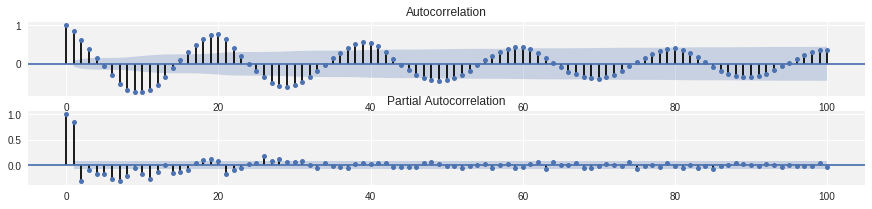

In [17]:
# Examine the series by plotting correlation functions
plot_acfs(ts_train, 100)

From the autocorrelation plots:


1.   The periodic  pattern in the ACF plot , provides the seasonality value (s= 20).

2.   The sudden drop in PACF plot at t =2 , suggest that there are 2 autoregressive terms are required for modeling while the ACF graph shows a slow decay again confirming the the presence of AR terms.

3. The d = 0 , as the series is already stationary. 
4. The q = 0 , as there is no sharp spike in ACF.



**Parameter Selection for the ARIMA Time Series Model**
The seasonal ARIMA model has following parameters  ARIMA(p,d,q)(P,D,Q)s . For each combination of parameters, we fit a seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality.

In [18]:
# Make the seasonal ARIMA model to predict future values of the series

# terms: (p,d,q) and (P,D,Q,s)
model = sm.tsa.SARIMAX(ts_train, order=(2,0,0), seasonal_order=(1,1,0,20),enforce_invertibility = False)
model_results = model.fit()
model_fit = model_results.predict()

# Show the fit quantitatively
print(model_results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  580
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 20)   Log Likelihood                -361.167
Date:                            Sun, 17 Feb 2019   AIC                            730.334
Time:                                    23:16:38   BIC                            747.786
Sample:                                01-01-2018   HQIC                           737.138
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7234      0.031     23.286      0.000       0.662       0.784
ar.L2         -0.1202      0.039   

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


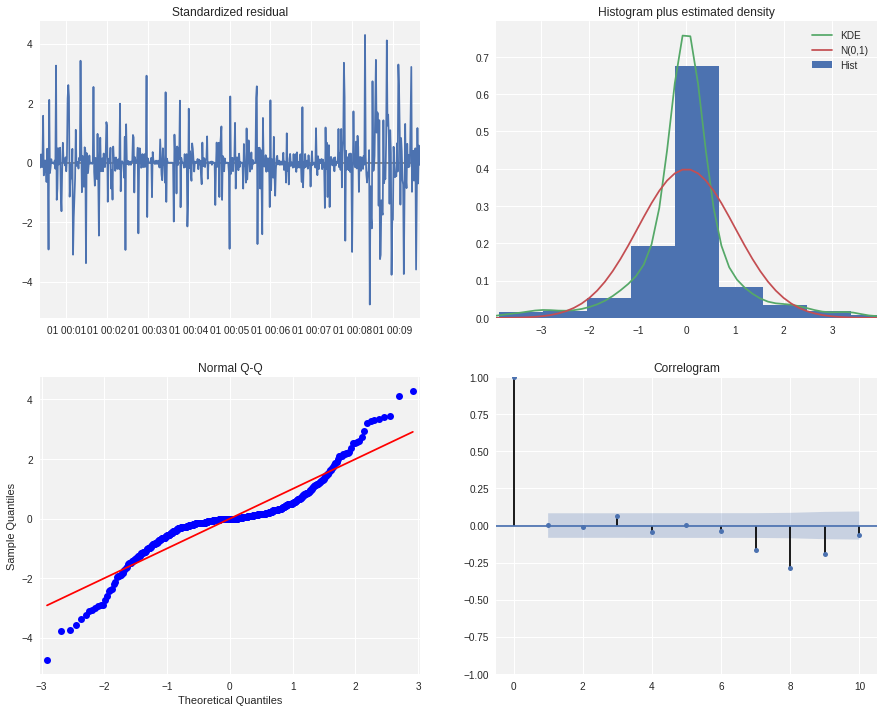

In [19]:
#Check whether the residuals of our model are uncorrelated and normally distributed.
model_results.plot_diagnostics(figsize=(15, 12))
plt.show()

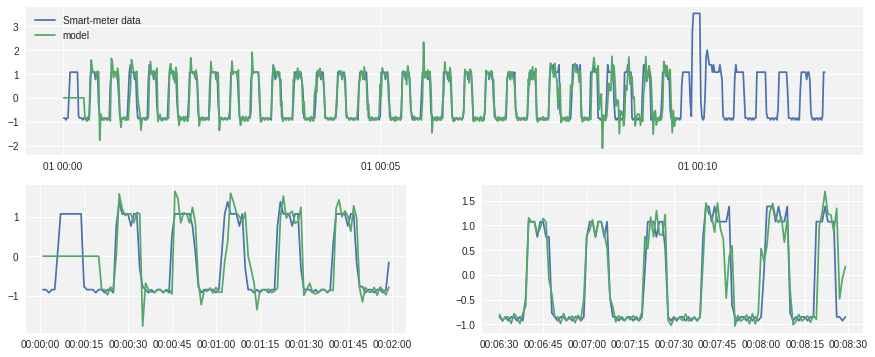

In [20]:
# Plot the model to visualize the fit with training data- 
plot_ts([ts_sec, 'Smart-meter data'], [model_fit, 'model'], plot_range1, plot_range2)

In [22]:
# Make the prediction 
# Establish start and end dates of the prediction

start_time_ord = ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:00:01'))
end_time_ord = ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:12:00'))

# Get the prediction results 
pred_results = model_results.predict(start=start_time_ord, end=end_time_ord)
print(pred_results[1:5])

2018-01-01 00:00:02   -2.156132e-07
2018-01-01 00:00:03   -3.314564e-07
2018-01-01 00:00:04   -4.088710e-07
2018-01-01 00:00:05   -4.277858e-07
Freq: S, dtype: float64


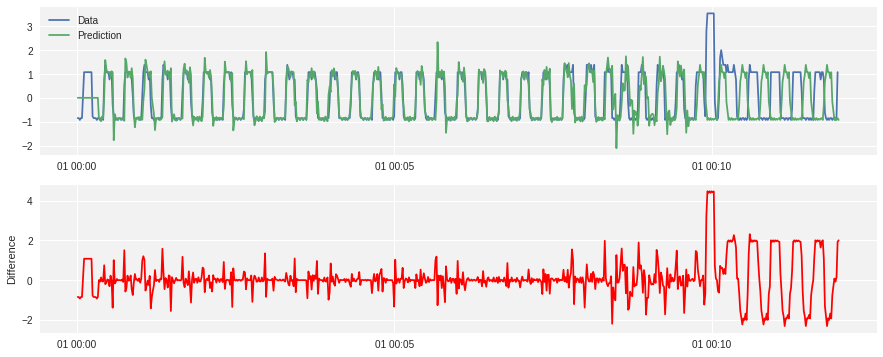

In [23]:

# Plot the results to see how the prediction compares with the data

fig = plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(ts_sec.ix[start_time_ord:end_time_ord], label='Data')
plt.plot(pred_results, label='Prediction')
plt.legend(loc='upper left')

# Examine the differences between the data and the prediction
ts_residual = ts_sec-pred_results

plt.subplot(212)
plt.plot(ts_residual, label='Difference', color='r');
plt.ylabel('Difference');

From the plot of the differences, the data between about 7:45 and 10:00 minutes appears be an early anomaly prior to the obvious anomaly at about 10:00. An alert can be established for both of these by setting thresholds, one at about 1.0-1.5 as a warning and one at a higher level for a critical alert.

In [24]:
# Find a threshold using the differences in the normal data and the prediction
warn_thresh = (ts_sec-pred_results).ix[
    ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:03:00')):
    ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:07:30'))
].max()

# Make an early warning and a critical alert
warn_thresh = (warn_thresh * 1.2).round(1)
alert_thresh = (warn_thresh * 2).round(1)
print('Warning : ' + str(warn_thresh))
print('Anomaly Alert:   ' + str(alert_thresh))

Anomaly Alert:   2.8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [0]:
# Find the anomalies
ts_warn = ts_sec[(ts_residual >= warn_thresh) & (ts_residual < alert_thresh)]
ts_alert = ts_sec[(ts_residual >= alert_thresh)]

In [26]:
ts_warn.head(100)

2018-01-01 00:00:45    0.53572
2018-01-01 00:01:21    0.76664
2018-01-01 00:07:48    1.07450
2018-01-01 00:08:19    1.07450
2018-01-01 00:08:35    1.38240
2018-01-01 00:08:51    1.07450
2018-01-01 00:09:08    0.53572
2018-01-01 00:09:27    1.07450
2018-01-01 00:09:45    0.53572
2018-01-01 00:09:46    1.07450
2018-01-01 00:10:15    1.38240
2018-01-01 00:10:16    1.07450
2018-01-01 00:10:17    1.07450
2018-01-01 00:10:18    1.07450
2018-01-01 00:10:19    1.07450
2018-01-01 00:10:20    1.07450
2018-01-01 00:10:21    1.38240
2018-01-01 00:10:22    1.07450
2018-01-01 00:10:23    0.76664
2018-01-01 00:10:36    1.38240
2018-01-01 00:10:37    1.07450
2018-01-01 00:10:38    1.07450
2018-01-01 00:10:39    1.07450
2018-01-01 00:10:40    1.07450
2018-01-01 00:10:41    1.07450
2018-01-01 00:10:42    1.07450
2018-01-01 00:10:43    1.07450
2018-01-01 00:10:56    1.07450
2018-01-01 00:10:57    1.07450
2018-01-01 00:10:58    1.07450
2018-01-01 00:10:59    1.07450
2018-01-01 00:11:00    1.07450
2018-01-

In [27]:
ts_alert.head(10)

2018-01-01 00:09:55    2.7680
2018-01-01 00:09:56    3.5377
2018-01-01 00:09:57    3.5377
2018-01-01 00:09:58    3.5377
2018-01-01 00:09:59    3.5377
2018-01-01 00:10:00    3.5377
2018-01-01 00:10:01    3.5377
2018-01-01 00:10:02    3.5377
Freq: S, dtype: float64

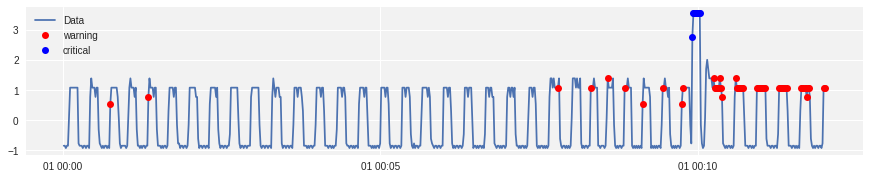

In [28]:
# Plot the results
fig = plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(ts_sec.ix[start_time_ord:end_time_ord], label='Data')
plt.plot(ts_warn, 'ro', label='warning')
plt.plot(ts_alert, 'bo', label='critical')
plt.legend(loc='upper left');
plt.savefig('Anomaly_SARIMA.png')

In [29]:
# Tuning the Hyperparameters 

# terms: (p,d,q) and (P,D,Q,s)
model = sm.tsa.SARIMAX(ts_train, order=(2,0,4), seasonal_order=(1,1,1,20),enforce_invertibility = False)
model_results = model.fit()
model_fit = model_results.predict()

# Show the fit quantitatively
print(model_results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  580
Model:             SARIMAX(2, 0, 4)x(1, 1, 1, 20)   Log Likelihood                -252.982
Date:                            Sun, 17 Feb 2019   AIC                            523.964
Time:                                    23:23:40   BIC                            563.232
Sample:                                01-01-2018   HQIC                           539.273
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8413      0.020     93.894      0.000       1.803       1.880
ar.L2         -0.9487      0.019   

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


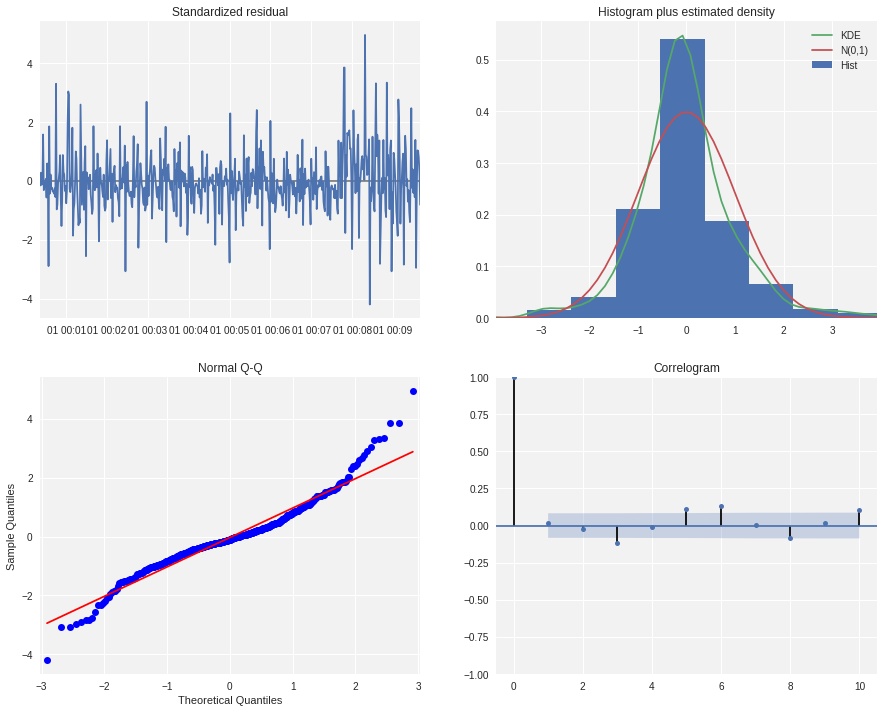

In [30]:
#Check whether the residuals of our model are uncorrelated and normally distributed.
model_results.plot_diagnostics(figsize=(15, 12))
plt.show()

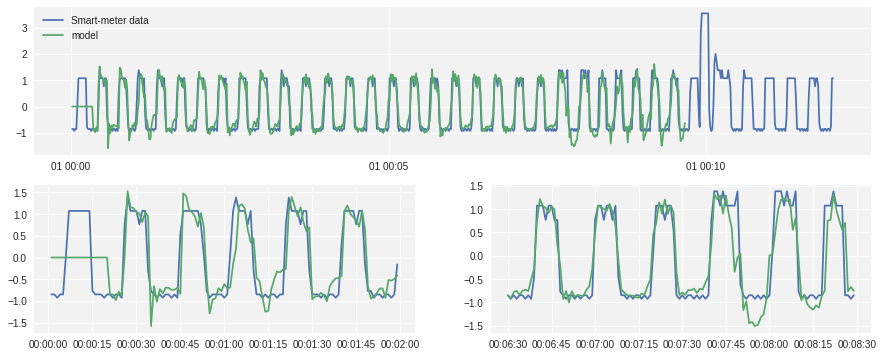

In [31]:
# Plot the model to visualize the fit
plot_ts([ts_sec, 'Smart-meter data'], [model_fit, 'model'], plot_range1, plot_range2)

In [32]:
# Make the prediction 

start_time_ord = ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:00:01'))
end_time_ord = ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:12:00'))

# Get the prediction results
pred_results = model_results.predict(start=start_time_ord, end=end_time_ord)
print(pred_results[1:5])

2018-01-01 00:00:02   -2.184535e-07
2018-01-01 00:00:03   -3.394109e-07
2018-01-01 00:00:04   -4.261851e-07
2018-01-01 00:00:05   -4.137635e-07
Freq: S, dtype: float64


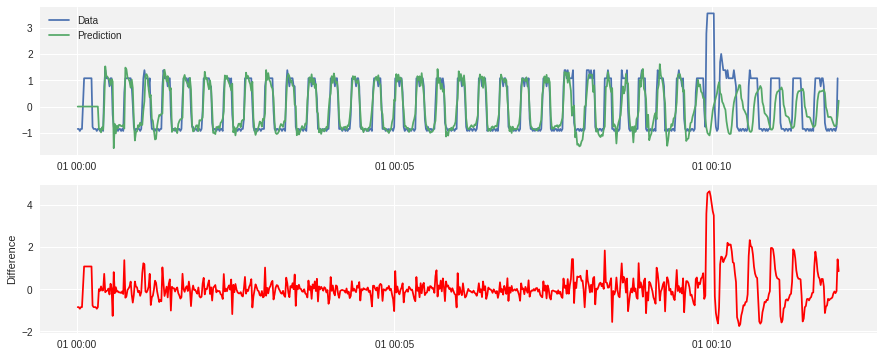

In [34]:

# Plot the results to see how the prediction compares with the data

fig = plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(ts_sec.ix[start_time_ord:end_time_ord], label='Data')
plt.plot(pred_results, label='Prediction')
plt.legend(loc='upper left')

# Examine the differences between the data and the prediction
ts_residual = ts_sec-pred_results

plt.subplot(212)
plt.plot(ts_residual, label='Difference', color='r');
plt.ylabel('Difference');

In [35]:
# Find a threshold using the differences in the normal data and the prediction
warn_thresh = (ts_sec-pred_results).ix[
    ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:03:00')):
    ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:07:30'))
].max()

# Make an early warning and a critical alert
warn_thresh = (warn_thresh * 1.2).round(1)
alert_thresh = (warn_thresh * 2).round(1)
print('Warning : ' + str(warn_thresh))
print('Anomaly Alert:   ' + str(alert_thresh))

Anomaly Alert:   2.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [0]:
# Find the anomalies
ts_warn = ts_sec[(ts_residual >= warn_thresh) & (ts_residual < alert_thresh)]
ts_alert = ts_sec[(ts_residual >= alert_thresh)]

In [37]:
ts_warn.head(50)

2018-01-01 00:00:45    0.53572
2018-01-01 00:01:03    1.07450
2018-01-01 00:01:04    1.38240
2018-01-01 00:07:48    1.07450
2018-01-01 00:07:49    1.38240
2018-01-01 00:08:19    1.07450
2018-01-01 00:08:35    1.38240
2018-01-01 00:08:51    1.07450
2018-01-01 00:10:08    1.69030
2018-01-01 00:10:09    1.99820
2018-01-01 00:10:10    1.69030
2018-01-01 00:10:11    1.38240
2018-01-01 00:10:12    1.38240
2018-01-01 00:10:13    1.38240
2018-01-01 00:10:14    1.07450
2018-01-01 00:10:15    1.38240
2018-01-01 00:10:16    1.07450
2018-01-01 00:10:17    1.07450
2018-01-01 00:10:18    1.07450
2018-01-01 00:10:19    1.07450
2018-01-01 00:10:20    1.07450
2018-01-01 00:10:21    1.38240
2018-01-01 00:10:35    0.76664
2018-01-01 00:10:37    1.07450
2018-01-01 00:10:38    1.07450
2018-01-01 00:10:39    1.07450
2018-01-01 00:10:56    1.07450
2018-01-01 00:10:57    1.07450
2018-01-01 00:10:58    1.07450
2018-01-01 00:10:59    1.07450
2018-01-01 00:11:17    1.07450
2018-01-01 00:11:18    1.07450
2018-01-

In [38]:
ts_alert.head(10)

2018-01-01 00:09:55    2.7680
2018-01-01 00:09:56    3.5377
2018-01-01 00:09:57    3.5377
2018-01-01 00:09:58    3.5377
2018-01-01 00:09:59    3.5377
2018-01-01 00:10:00    3.5377
2018-01-01 00:10:01    3.5377
2018-01-01 00:10:02    3.5377
2018-01-01 00:10:36    1.3824
dtype: float64

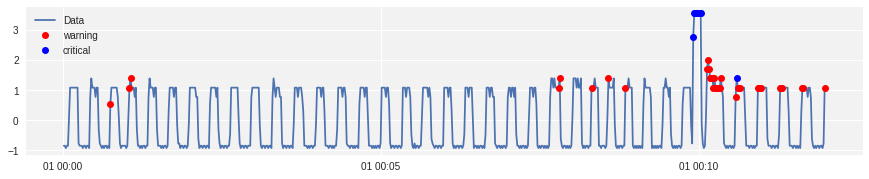

In [39]:
# Plot the results
fig = plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(ts_sec.ix[start_time_ord:end_time_ord], label='Data')
plt.plot(ts_warn, 'ro', label='warning')
plt.plot(ts_alert, 'bo', label='critical')
plt.legend(loc='upper left');
plt.savefig('Anomaly1_SARIMA2.png')

In [40]:
# Tuning the Hyperparameters 

# terms: (p,d,q) and (P,D,Q,s)
model = sm.tsa.SARIMAX(ts_train, order=(2,0,4), seasonal_order=(2,1,1,20),enforce_invertibility = False)
model_results = model.fit()
model_fit = model_results.predict()

# Show the fit quantitatively
print(model_results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  580
Model:             SARIMAX(2, 0, 4)x(2, 1, 1, 20)   Log Likelihood                -245.723
Date:                            Sun, 17 Feb 2019   AIC                            511.447
Time:                                    23:28:33   BIC                            555.077
Sample:                                01-01-2018   HQIC                           528.457
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8725      0.013    142.022      0.000       1.847       1.898
ar.L2         -0.9764      0.013   

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


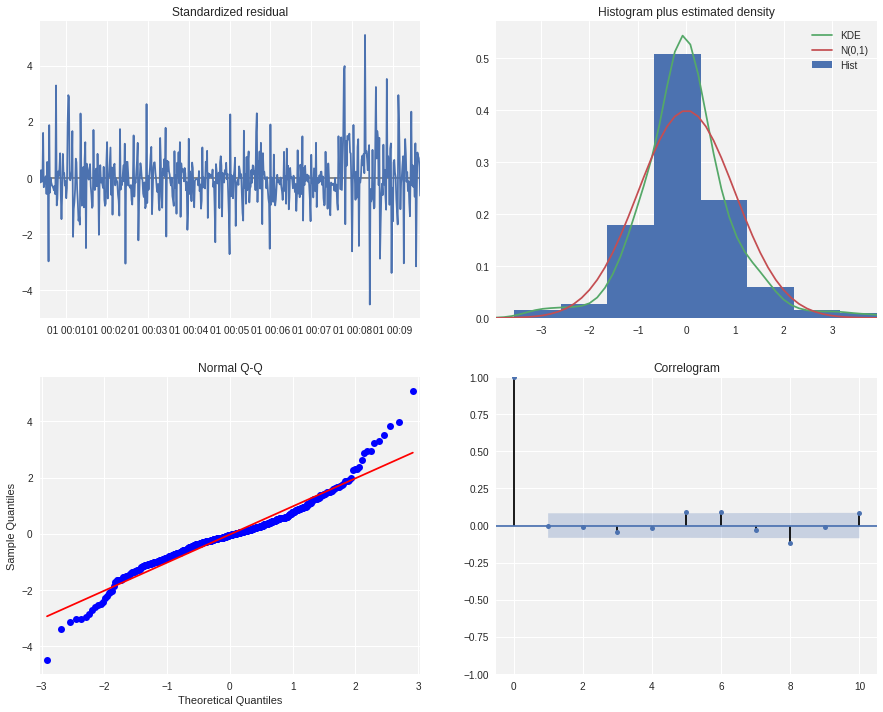

In [41]:
#Check whether the residuals of our model are uncorrelated and normally distributed.
model_results.plot_diagnostics(figsize=(15, 12))
plt.show()

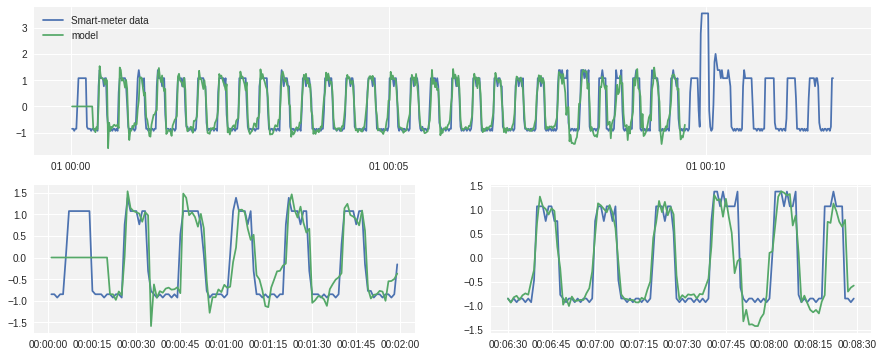

In [42]:
# Plot the model to visualize the fit
plot_ts([ts_sec, 'Smart-meter data'], [model_fit, 'model'], plot_range1, plot_range2)

In [43]:
# Make the prediction 

start_time_ord = ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:00:01'))
end_time_ord = ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:12:00'))

# Get the prediction results
pred_results = model_results.predict(start=start_time_ord, end=end_time_ord)
print(pred_results[1:5])

2018-01-01 00:00:02   -1.798216e-07
2018-01-01 00:00:03   -2.613114e-07
2018-01-01 00:00:04   -3.090754e-07
2018-01-01 00:00:05   -2.846620e-07
Freq: S, dtype: float64


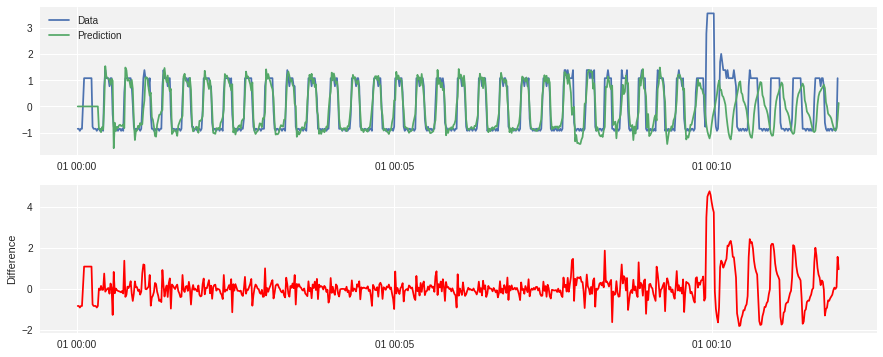

In [44]:

# Plot the results to see how the prediction compares with the data

fig = plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(ts_sec.ix[start_time_ord:end_time_ord], label='Data')
plt.plot(pred_results, label='Prediction')
plt.legend(loc='upper left')

# Examine the differences between the data and the prediction
ts_residual = ts_sec-pred_results

plt.subplot(212)
plt.plot(ts_residual, label='Difference', color='r');
plt.ylabel('Difference');

In [45]:
# Find a threshold using the differences in the normal data and the prediction
warn_thresh = (ts_sec-pred_results).ix[
    ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:03:00')):
    ts_sec.index.get_loc(pd.to_datetime('2018-01-01 00:07:30'))
].max()

# Make an early warning and a critical alert
warn_thresh = (warn_thresh * 1.5).round(1)
alert_thresh = (warn_thresh * 2).round(1)
print('Warning : ' + str(warn_thresh))
print('Anomaly Alert:   ' + str(alert_thresh))

Anomaly Alert:   2.6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [0]:
# Find the anomalies
ts_warn = ts_sec[(ts_residual >= warn_thresh) & (ts_residual < alert_thresh)]
ts_alert = ts_sec[(ts_residual >= alert_thresh)]

In [47]:
ts_warn.head(50)

2018-01-01 00:00:45    0.53572
2018-01-01 00:07:48    1.07450
2018-01-01 00:07:49    1.38240
2018-01-01 00:08:19    1.07450
2018-01-01 00:10:09    1.99820
2018-01-01 00:10:13    1.38240
2018-01-01 00:10:14    1.07450
2018-01-01 00:10:15    1.38240
2018-01-01 00:10:16    1.07450
2018-01-01 00:10:17    1.07450
2018-01-01 00:10:18    1.07450
2018-01-01 00:10:19    1.07450
2018-01-01 00:10:20    1.07450
2018-01-01 00:10:21    1.38240
2018-01-01 00:10:35    0.76664
2018-01-01 00:10:36    1.38240
2018-01-01 00:10:37    1.07450
2018-01-01 00:10:38    1.07450
2018-01-01 00:10:39    1.07450
2018-01-01 00:10:40    1.07450
2018-01-01 00:10:56    1.07450
2018-01-01 00:10:57    1.07450
2018-01-01 00:10:58    1.07450
2018-01-01 00:10:59    1.07450
2018-01-01 00:11:17    1.07450
2018-01-01 00:11:18    1.07450
2018-01-01 00:11:19    1.07450
2018-01-01 00:11:38    1.07450
2018-01-01 00:11:39    1.07450
2018-01-01 00:11:59    1.07450
dtype: float64

In [48]:
ts_alert.head(10)

2018-01-01 00:09:55    2.7680
2018-01-01 00:09:56    3.5377
2018-01-01 00:09:57    3.5377
2018-01-01 00:09:58    3.5377
2018-01-01 00:09:59    3.5377
2018-01-01 00:10:00    3.5377
2018-01-01 00:10:01    3.5377
2018-01-01 00:10:02    3.5377
Freq: S, dtype: float64

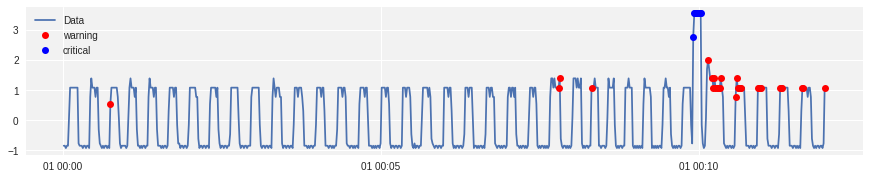

In [49]:
# Plot the results
fig = plt.figure(figsize=(15,6))
plt.subplot(211)
plt.plot(ts_sec.ix[start_time_ord:end_time_ord], label='Data')
plt.plot(ts_warn, 'ro', label='warning')
plt.plot(ts_alert, 'bo', label='critical')
plt.legend(loc='upper left');
plt.savefig('Anomaly1_SARIMA3.png')

Finally , precision is calculated by calcuating the true positives and false positives for the respective models.